# Racial and ethnic disparities in COVID‐19 testing 

#### By: Tony Liang, Jack Fan, Minghao Wang

## 1. Introduction

### 1.1 Background information on the topic

A growing body of research suggests that race and ethnicity may affect the infection rates of COVID-19. Humans and viruses have been battling for thousands of years. We have encountered Black Death, Yellow Fever, 2009 H1N1, Spanish Flu, and more. These diseases have impacted us significantly throughout our history, killing millions of people and changing how our society was shaped. With the visit of COVID-19, people are feared and have taken some of the safety measures that we have never seen before, such as wearing masks. Covid-19 is an infectious disease, and it makes people wonder if race is an essential factor affecting novel Coronavirus infection rates, including different socioeconomic statuses and the different history of degrees of coronavirus exposure.

### 1.2 The Question 

Through this group project, we wish to answer the question: 
We want to compare whether there exist significant differences in the proportion of tested positive for COVID-19 among Black, White, Latin and Asian people in the State of the USA, with most cases in 2021. We selected these ethnicities because they are the composition of the population of the vast majority's cities in the world, and we chose explicitly in the year 2021 because that is where most cases occurred. More observations existed in the database, grouping these with `State` variables.


### 1.3 The Dataset

We will use the CRDT Data Set to answer the question mentioned above. This dataset is based on the states' race and ethnicity reports on the pandemic across the United States, collected by Boston University Center for Antiracist Research. It consists of several numerical variables (cases, deaths of different races) and one categorical variable (State). For more information on the data we used, you can find it on the [Covid Tracking Project](https://covidtracking.com/race/about#download-the-data). About the Racial Data Tracker. (n.d.)


## 2. Methods and Results

### 2.0 Libraries and Packages

In [2]:
#install.packages("ggrepel")
suppressMessages(library(tidyverse))
suppressMessages(library(readr))
suppressMessages(library(tidyr))
suppressWarnings(library(dbplyr))
suppressWarnings(library(lubridate))
suppressWarnings(library(ggplot2))
suppressWarnings(library(ggrepel))

### 2.1 Read the data into R

In [158]:
df <- read_csv("crdt-data.csv")
cat("The dimenstion of this dataframe is: ", dim(df)[1], "x", dim(df)[2])
head(df)


Rows: 5320 Columns: 54

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): State
dbl (53): Date, Cases_Total, Cases_White, Cases_Black, Cases_Latinx, Cases_A...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



The dimenstion of this dataframe is:  5320 x 54

Date,State,Cases_Total,Cases_White,Cases_Black,Cases_Latinx,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,⋯,Tests_Latinx,Tests_Asian,Tests_AIAN,Tests_NHPI,Tests_Multiracial,Tests_Other,Tests_Unknown,Tests_Ethnicity_Hispanic,Tests_Ethnicity_NonHispanic,Tests_Ethnicity_Unknown
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20210307,AK,59332,18300,1499,NA,2447,12238,1508,4453,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AL,499819,160347,82790,NA,2273,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AR,324818,207596,50842,NA,2913,1070,3358,1804,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AS,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,AZ,826454,308453,25775,244539,11921,40707,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
20210307,CA,3501394,546630,111279,1509103,186562,9025,15281,42824,⋯,9444459,3980518,98894,222513,74171,6354689,18567612,9444459,21633943,18567612


After reading data, we noticed that this raw data consists of 5320 observations (rows) and 54 variables (columns), whereas there exist many NA values. This suggests that we need to clean and wrangle it into a tidier data to work with, plus, selecting our interest variables. We are interested in estimating proportions of tested positive among selected ethnicities, and categorize them by `Date`, `State`. Hence, we will only keep the following variables:
`Cases_White`, `Cases_Black`, `Cases_Latinx`, `Cases_Asian`, `Date`,`State`. 
<br>
</br>

Note: The `Cases_Total` in the dataset is sum of multiple ethnicities of not only those mentioned above, hence we will not select that it but instead generating a new `Total_pos` column , such that it is equal to `Cases_White` + `Cases_Black` + `Cases_Latinx`+ `Cases_Asian`, therefore when calulating proportion, they add up to 1, such they are on the same scale.

Moreover, for the simplicity of this project, we will assume these data were Missing Completely At Random (MCAR), therefore dropping all NA values. 

### 2.2 Clean and wrangle data into a tidy format

In [5]:
cases_piped <- df %>%
    select(Date, State, Cases_White:Cases_Asian) %>%
    drop_na() 
head(cases_piped)
cat("The dimenstion of cases_piped is: ", 
    dim(cases_piped)[1], "x", dim(cases_piped)[2])

Date,State,Cases_White,Cases_Black,Cases_Latinx,Cases_Asian
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
20210307,AZ,308453,25775,244539,11921
20210307,CA,546630,111279,1509103,186562
20210307,CO,181669,12637,119224,6406
20210307,CT,85469,19651,41523,3019
20210307,DE,42730,19768,14532,1842
20210307,GA,319208,216068,85460,17888


The dimenstion of cases_piped is:  1941 x 6

After selecting only those interested variables (mentioned above) and dropping the NA values, we noticed the data is still a bit large and unorganized, plus, `Date` is shown in YYYYMMDD format, and the total number states is also unknown. Hence, we will separate this `Date` column into `Year`, `Month`, `Day`, then look for time spread, plus, unique values of States in here as data formatted as reports on cases from all states weekly.

In [7]:
cases_tidy <- cases_piped %>%
           mutate(Date = lubridate::ymd(Date),
                  Year = lubridate::year(Date),
                  Month = lubridate::month(Date),
                  Day = lubridate::day(Date)) %>%
           select(-Date)

years <- cases_tidy %>%
         select(Year) %>%
         unique() %>%
         t() 

n_states <- length(unique(cases_tidy$State))

cat("The total number of unquie and non-NA States in this dataframe is: ", n_states, "\n")
years

The total number of unquie and non-NA States in this dataframe is:  23 


Year,2021,2020


The tidy data only contains observations of `Year` of 2021 and 2020, and total of 23 states that are unique and have <b> no NAs</b>. Then, we will find only in `Year = 2021` (reason mentioned earlier) , `State` whose occured most cases by adding them all together and assigned it to a dataframe called `max_cases`.

In [9]:
options(repr.plot.width = 10, repr.plot.height = 10)
max_cases <- cases_tidy %>%
           filter(Year == 2021) %>%
           ungroup() %>%
           select(-Year) %>%
           group_by(State) %>%
           summarize(Total_pos = sum(Cases_Asian, Cases_White, Cases_Black, Cases_Latinx)) %>% 
           arrange(desc(Total_pos))
head(max_cases)

State,Total_pos
<chr>,<dbl>
CA,39044983
IL,14230188
GA,10564091
AZ,9752653
NJ,8381060
MN,7650507


A visualization of total number of positive cases of these 23 states is represented at section 2.3 (See below)

Given the dataframe above, California (CA) has highest number of positive cases of the pandemic in 2021, so we will focus on `State == "CA"` and in `Year == 2021` only

In [20]:
tidy_ca <- cases_tidy %>%
           filter(State == "CA", Year == 2021) %>%
           select(-Year, -Day, -Month)

head(tidy_ca)

State,Cases_White,Cases_Black,Cases_Latinx,Cases_Asian
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
CA,546630,111279,1509103,186562
CA,541927,110115,1494376,184765
CA,539466,109591,1487225,183711
CA,534330,108479,1472040,181664
CA,530958,107741,1462751,180258
CA,524753,106400,1446427,177919


### 2.3 Plot the relevant raw data, tailoring your plot in a way that addresses your question.

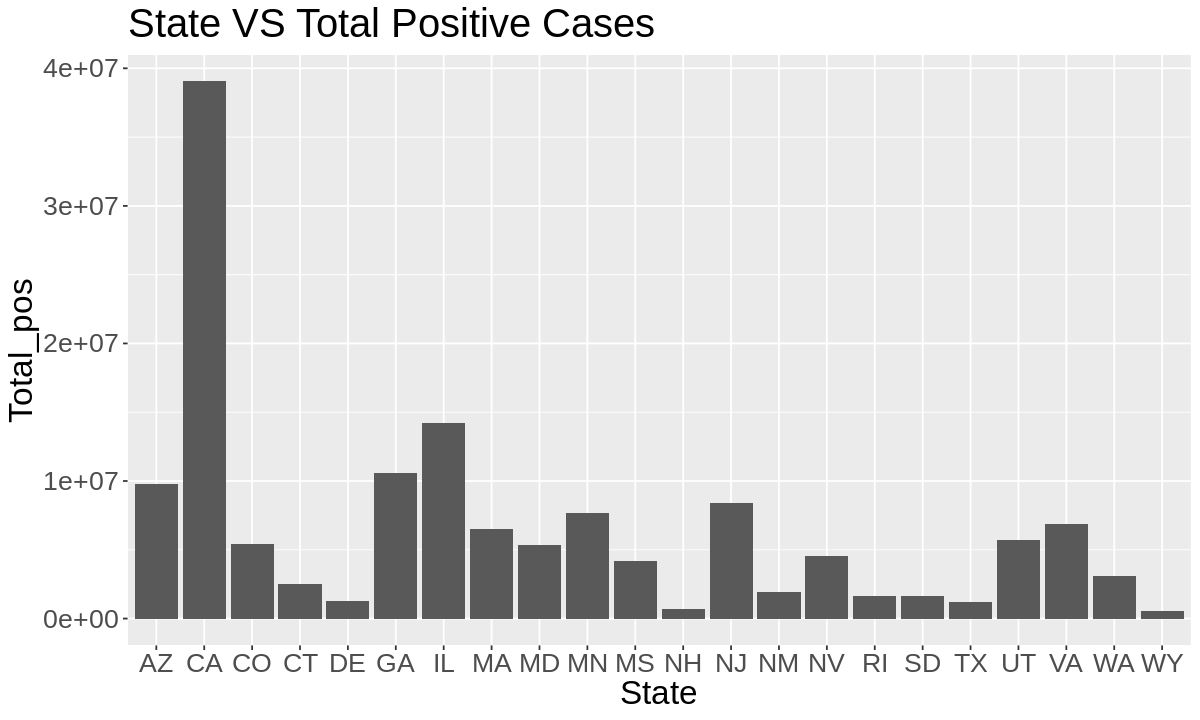

In [21]:
options(repr.plot.width=10, repr.plot.height=6)
cases_plot <- ggplot(max_cases, aes(x = State, y = Total_pos)) + 
              geom_bar(stat = "identity") + 
              labs(title = "State VS Total Positive Cases") +
              theme(text = element_text(size = 20))
cases_plot


By the plot above, total positive cases of California is significantly higher than other states, therefore, we would focus on California's data only , and calculate the proportion of different ethinicities getting tested positive for COVID-19 eg. for White, Black, Asian and Latin people during the year of 2021.

### 2.4 Compute estimates 

In [59]:
cali_prop <- tidy_ca %>%
              summarize(Total_pos = sum(Cases_White, Cases_Asian, Cases_Black, Cases_Latinx),
                        Asian = round(sum(Cases_Asian) / sum(Total_pos),4),
                        Black = round(sum(Cases_Black) / sum(Total_pos),4),
                        Latinx = round(sum(Cases_Latinx) / sum(Total_pos),4),
                       White = round(sum(Cases_White) / sum(Total_pos),4)) %>%
               select(-Total_pos) %>%
              pivot_longer(cols = 1:4,
                          names_to = "ethnicity") %>%
              rename(proportion = value) %>%
              arrange(desc(proportion))

cali_prop

ethnicity,proportion
<chr>,<dbl>
Latinx,0.6405
White,0.2318
Asian,0.0776
Black,0.0501


Below is the visualization of these summary statistics(estimates):

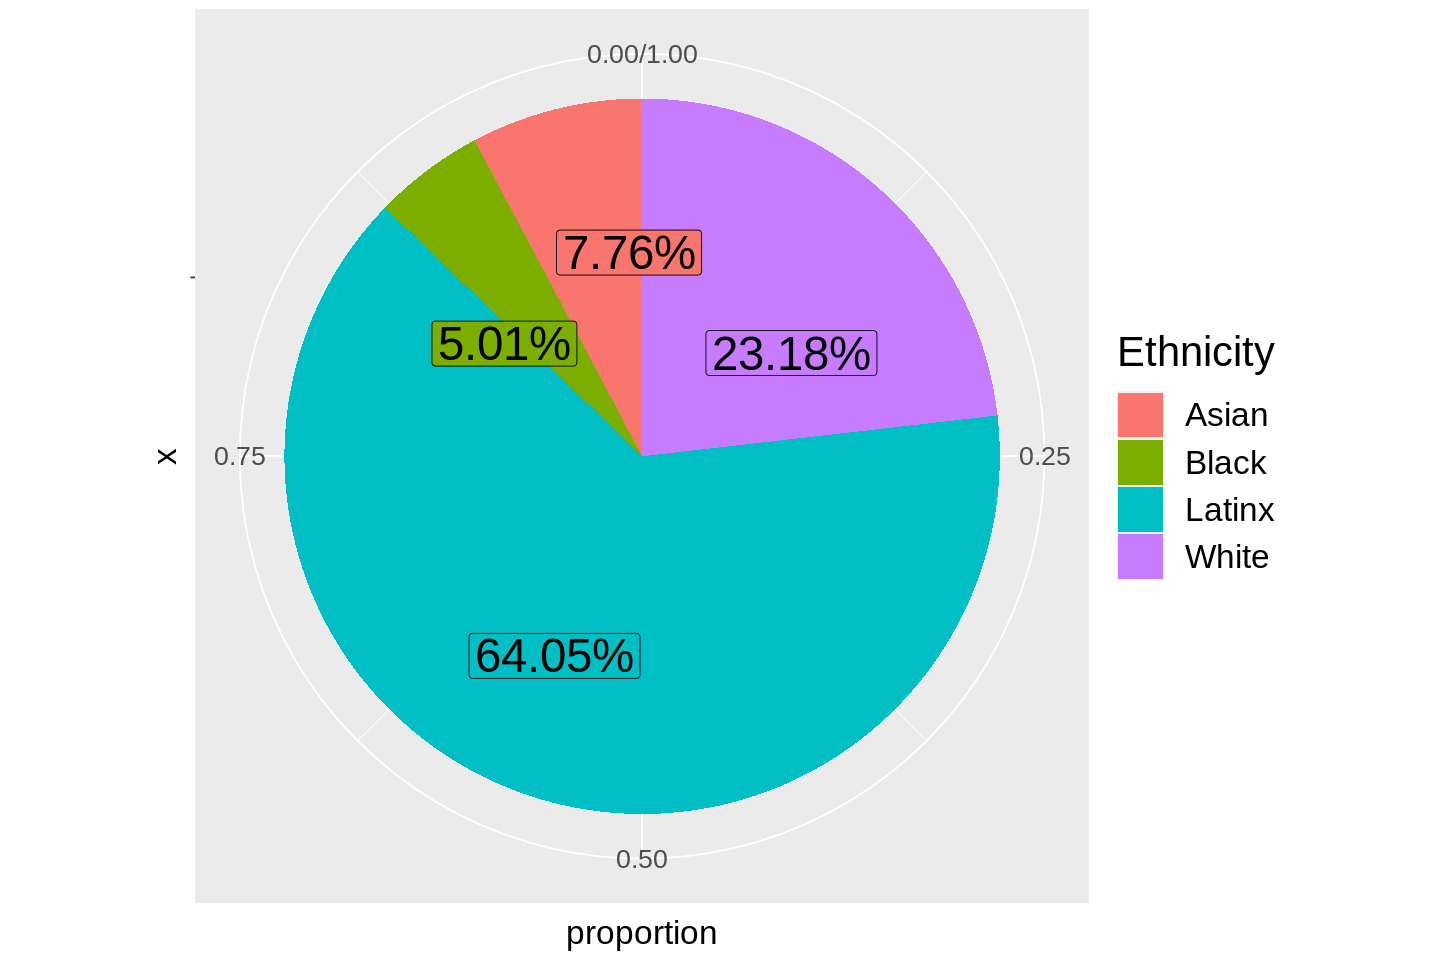

In [60]:
options(repr.plot.width = 12, repr.plot.height = 8)
pie <- ggplot(cali_prop, aes(x = "", y = proportion, fill = ethnicity)) +
     geom_bar(width = 1, stat = "identity") +
     coord_polar(theta = "y") +
     theme(text = element_text(size = 20),
         legend.key.size = unit(1, "cm"),
           legend.key.height = unit(1, "cm"),
            legend.key.width = unit(1, "cm"),
            legend.title = element_text(size = 25),
            legend.text = element_text(size = 20)) +
          geom_label_repel(aes(label = paste0(round(proportion * 100, 2), "%")),
                               size = 10,
                           show.legend = F, position = position_stack(vjust = 0.5)) + 
       guides(fill = guide_legend(title = "Ethnicity")) 
pie

### 2.5 Method set up

By doing this project, we want to explore and find out if distinct races have different chances of catching COVID-19, or they all races have the same chance. But, since we dont know the population distribution in the `State` we found earlier (<b>CA</b>), we could instead make pairwise comparison between the ethnicies. Since we have 4 races, it will be necessary to perform ${4 \choose 2} = 6$ hypothesis tests: 
Let the following be our hypotheses:

Let $a =$ Asian , $b =$ Black, $l =$ Latinx , $w =$ White

1. $H_{0}: p_a = p_b$ VS $H_{A}: p_a \neq p_b$

2. $H_{0}: p_a = p_l$ VS $H_{A}: p_a \neq p_l$

3. $H_{0}: p_a = p_w$ VS $H_{A}: p_a \neq p_w$

4. $H_{0}: p_b = p_l$ VS $H_{A}: p_b \neq p_l$

5. $H_{0}: p_b = p_w$ VS $H_{A}: p_b \neq p_w$

6. $H_{0}: p_l = p_w$ VS $H_{A}: p_l \neq p_w$

All at $\alpha = 0.05$, given our dataset was collected by random sampling, and observations independent of others, we would use asymtoptics to compute test stastics and evaluate our hypotheses in the section below  


### 2.6 Test Statistics and Results

We have calculated sample proportions for the 4 races earlier and assigned it to `Cali_prop`, therefore we just need to grab proportions from there and calculate their respective test statistic : 
$$
Z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}
$$
where $\hat{p}_1$ and $\hat{p}_2$ are the sample proportions in samples 1 and 2, respectively; $n$ is the sample size; and $\hat{p}$ is the pooled proportion, given by: 

$$\hat{p} = \frac{n_1\hat{p}_1+n_2\hat{p}_2}{n_1+n_2}$$ 

But since in our case n is same among races, hence the above formula would turn to the following:

$$
Z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n} + \frac{1}{n}\right)}}
$$

And,
$$\hat{p} = \frac{\hat{p}_1+\hat{p}_2}{n}$$ 

Since, in this case, we dont know if population distribution is normal or not, hence we need to rely on the CLT. 

In [157]:
n <- nrow(tidy_ca)
# Pooled proportions
p_hats <- cali_prop %>%
              arrange(ethnicity) %>%
              summarize(pab = round((proportion[1] + proportion[2]) / n ,4),
                    pal = round((proportion[1] + proportion[3]) / n, 4),
                    paw = round((proportion[1] + proportion[4]) / n, 4),
                    pbl = round((proportion[2] + proportion[3]) / n, 4),
                    pbw = round((proportion[2] + proportion[4]) / n, 4),
                    plw = round((proportion[3] + proportion[4]) / n, 4)) %>%
                    pivot_longer(cols = 1:6,
                                names_to = "pooled_phat")
pab = p_hats[1,] %>% pull()
pal = p_hats[2,] %>% pull()
paw = p_hats[3,] %>% pull()
pbl = p_hats[4,] %>% pull()
pbw = p_hats[5,] %>% pull()
plw = p_hats[6,] %>% pull()

# Calculating test stats
test_stats <- cali_prop %>%
              arrange(ethnicity) %>%
              summarize(Tab = (proportion[1] - proportion[2]) / sqrt(pab*(1-pab) * (1/(2*n))) ,
                                       Tal = (proportion[1] - proportion[3]) / sqrt(pal*(1-pal) * (1/(2*n))) ,
                                       Taw = (proportion[1] - proportion[4]) / sqrt(paw*(1-paw) * (1/(2*n))) ,
                                       Tbl = (proportion[2] - proportion[3]) / sqrt(pbl*(1-pbl) * (1/(2*n))) ,
                                       Tbw = (proportion[2] - proportion[4]) / sqrt(pbw*(1-pbw) * (1/(2*n))) ,
                                       Tlw = (proportion[3] - proportion[4]) / sqrt(plw*(1-plw) * (1/(2*n)))) %>%
              pivot_longer(cols = 1:6,
                                names_to = "T")  

# Test it with significance level
alpha = 0.05
test_results <- test_stats %>%
                rename(stat = value) %>%
                mutate(reject = 2 *pt(stat, 19, lower.tail = FALSE)< alpha)
test_results


T,stat,reject
<chr>,<dbl>,<lgl>
Tab,2.078006,FALSE
Tal,-18.194682,FALSE
Taw,-7.506734,FALSE
Tbl,-19.458704,FALSE
Tbw,-9.275849,FALSE
Tlw,12.039076,TRUE


## 3. Discussion

### 3.1 Interpretation

Recall our hypotheses, by above table we could interpret the following results:
1. $H_{0}: p_a = p_b$ VS $H_{A}: p_a \neq p_b$

2. $H_{0}: p_a = p_l$ VS $H_{A}: p_a \neq p_l$

3. $H_{0}: p_a = p_w$ VS $H_{A}: p_a \neq p_w$

4. $H_{0}: p_b = p_l$ VS $H_{A}: p_b \neq p_l$

5. $H_{0}: p_b = p_w$ VS $H_{A}: p_b \neq p_w$

6. $H_{0}: p_l = p_w$ VS $H_{A}: p_l \neq p_w$

At a significance level of $\alpha = 0.05$, we will reject the $6$th hypothesis. We can conclude that the probability of a Latin person getting tested positive for COVID-19 is different from the probability of a White person in the state of California during the year 2021; this is subjected to $5\%$ of Type-I error. It also means a difference between the four races because, for our null hypothesis, we set that every race has an equal chance of getting infected by COVID-19, hence we can draw conclusion on our research question:

    `Is there significant difference in chances of getting tested positive for COVID-19 in CA during 2021 for ethnicities like Asian, Black, Latin, White?`
    
    
As mentioned above, there is a difference between the four races, and we have enough evidence to reject our null hypotheses. Therefore, the chance of getting tested positive for COVID-19 in California in 2021 among the four different races is not the same.

As bootstrapping was not feasible in our context; hence we had to choose an asymptotic method to do hypothesis testing. Moreover, this showed that human beings in front of natural catastrophes or unexpected events, the vulnerability is not the same; therefore, a particular race is more dangerous when facing pandemics like COVID-19.


### 3.2 What impact could such findings have?

The impact of our findings could help raise the awareness of COVID-19 as well as other infectious diseases, and it is not just for a specific race but for all. It could also be a factor and help explain why different regions or countries have different measurements of cases of COVID-19 as compared to others. On top of that, governments worldwide could implement different regulations and medical procedures for their citizens to help different control diseases.

### 3.3 What future questions could this lead to?

As mentioned above, the result of this project could lead to various questions. These include why this is the case, what can a specific race do to lower the chance of getting infected from different diseases, what they can do to improve their health status and immune system, what they should be aware of, and the effects on. The importance of this project is unquestionable, and the result of this project can lead to evolutionary questions to modern health questions. 


### 3.4 Limitations

Although this report is carefully and precisely analyzed, limitations still do exist. Different proportions of different races living within a region could significantly affect and impact the result. On top of that, different races could possibly have different occupations, therefore increasing or decreasing the contact of COVID-19 carriers. That could be a factor in the virus's transmission rate and impact the result. Other methodologies could be applied, such as putting more weight on the minority race and less on the majority race. This could help adjust them and make them into the same scale. The sample size and the missing values can be a considerable flaw in this report; some underlying co-funding variables are also unknown. Finally, we genuinely hope that this report could help or engage other researchers and scholars to explore further and study this field.

## 4. Reference


Mankowski, N., Al-Qurayshi, Z., Souza, S., Campbell, B., Beighley, A., Denson, J., Mauldin, B., Bojanowski, C., Friedlander, P., & Zifodya, J. (2021). The Effect of Race, Socioeconomic Status, and Comorbidity on Patients Afflicted with COVID 19: A Local Perspective. Annals of Epidemiology. https://doi.org/10.1016/j.annepidem.2021.09.013
<br>

Credit, K. (2020). Neighbourhood inequity: Exploring the factors underlying racial and ethnic disparities in COVID‐19 testing and infection rates using ZIP code data in Chicago and New York. Regional Science Policy & Practice, 12(6), 1249–1271. https://doi.org/10.1111/rsp3.12321

About the Racial Data Tracker. (n.d.). The COVID Tracking Project. Retrieved March 6, 2022, from https://covidtracking.com/race/about#download-the-data
‌